## Lexicon approach

### Using AFINN lexicon

Defaultdict is a container like dictionaries present in the module collections. Defaultdict is a sub-class of the dict class that returns a dictionary-like object. The functionality of both dictionaries and defualtdict are almost same except for the fact that defualtdict never raises a KeyError. It provides a default value for the key that does not exists.

Besides the performance gain, using BytesIO instead of concatenating has the advantage that BytesIO can be used in place of a file object. So say you have a function that expects a file object to write to. Then you can give it that in-memory buffer instead of a file.

In [6]:
from collections import defaultdict
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

url = urlopen('http://www2.compute.dtu.dk/~faan/data/AFINN.zip')
zipfile = ZipFile(BytesIO(url.read()))
afinn_file = zipfile.open('AFINN/AFINN-111.txt')

afinn = dict()

for line in afinn_file:
    parts = line.strip().split()
    if  len(parts) == 2:
        afinn[parts[0].decode("utf-8")] = int(parts[1])

print('read %d AFINN terms.\nE.g.: %s' % (len(afinn), str(list(afinn.items())[:10])))

read 2462 AFINN terms.
E.g.: [('abandon', -2), ('abandoned', -2), ('abandons', -2), ('abducted', -2), ('abduction', -2), ('abductions', -2), ('abhor', -3), ('abhorred', -3), ('abhorrent', -3), ('abhors', -3)]


In [7]:
type(parts)

list

In [8]:
parts

[b'zealous', b'2']

In [9]:
parts[0]

b'zealous'

In [10]:
parts[1]

b'2'

In [11]:
parts[0].decode('utf-8')

'zealous'

In [12]:
int(parts[1])

2

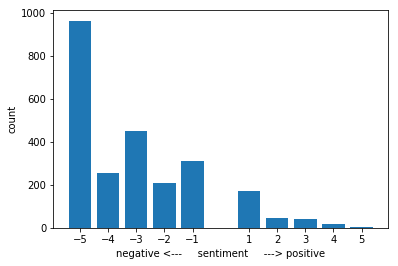

In [13]:
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

counts = Counter(afinn.values())
vals = sorted(counts.keys())

plt.bar(vals, counts.values())
plt.xticks(vals)
plt.xlabel("negative <---     sentiment     ---> positive")
plt.ylabel('count')
plt.show()

In [14]:
counts

Counter({-2: 962,
         -3: 256,
         2: 448,
         1: 208,
         -1: 309,
         3: 170,
         4: 45,
         -4: 43,
         -5: 16,
         5: 5})

### Score distribution

We now know what to do with the word polarity. but scoring a sentence or a documnet with number of sentiment words is done as shown below

In [15]:
def afinn_sentiment(terms, afinn):
    total = 0 
    for t in terms:
        if t in afinn:
            print('\t %s=%d' % (t, afinn[t]))
            total += afinn[t]
    return total

In [16]:
doc = "i don't know if this is a scam or mine was broken".split()
print('AFINN: ', afinn_sentiment(doc,afinn))

	 scam=-2
	 broken=-1
AFINN:  -3


Dealing with polarity when words are neutral or has mixed sentiments

In [17]:
doc = "is there a way to say if this was good or bad".split()
print('AFINN: ', afinn_sentiment(doc,afinn))

	 good=3
	 bad=-3
AFINN:  0


Returning two scores per document may help distinguish neutral from positive and negative

In [18]:
def afinn_sentiment2(terms, afinn, verbose=False):
    pos = 0
    neg = 0
    for t in terms:
        if t in afinn:
            if verbose:
                print('\t %s=%d' % (t, afinn[t]))
            if afinn[t] > 0:
                pos += afinn[t]
            else:
                neg += -1 * afinn[t]
    return pos, neg

doc = "it has a  hokey plot that is both too good and bad".split()
print('AFINN:', afinn_sentiment2(doc, afinn, verbose=True))
                

	 good=3
	 bad=-3
AFINN: (3, 3)


In [19]:
doc = "the plot is not bad but worse".split()
print('AFINN:', afinn_sentiment2(doc, afinn, verbose=True))

	 bad=-3
	 worse=-3
AFINN: (0, 6)


In [20]:
doc = "the review called it best ever, personally i think it is just good if not bad".split()
print('AFINN:', afinn_sentiment2(doc, afinn, verbose=True))

	 best=3
	 good=3
	 bad=-3
AFINN: (6, 3)


### Using Twitter data

In [22]:
import configparser
from TwitterAPI import TwitterAPI

# Get some tweets about McDonald's

def get_twitter(config_file):
    """ Read the config_file and construct an instance of TwitterAPI.
    Args:
      config_file ... A config file in ConfigParser format with Twitter credentials
    Returns:
      An instance of TwitterAPI.
    """
    config = configparser.ConfigParser()
    config.read(config_file)
    twitter = TwitterAPI(
                   config.get('twitter', 'consumer_key'),
                   config.get('twitter', 'consumer_secret'),
                   config.get('twitter', 'access_token'),
                   config.get('twitter', 'access_token_secret'))
    return twitter

twitter = get_twitter('twitter.cfg')
tweets = []
for r in twitter.request('search/tweets',
                         {'q': 'mcdonalds', 
                          'count': 100, 
                          'lang': 'en'}):
    if r['user']['screen_name'] != 'mcdonalds': # exclude tweets from @mcdonalds
        tweets.append(r)

In [23]:
print('read %d mcdonalds tweets' % len(tweets))

read 100 mcdonalds tweets


In [27]:
import re

# \w = [a-zA-Z0-9_]
def tokenize(text):
    return re.sub('\W+', ' ', text.lower()).split()

tokens = [tokenize(t['text']) for t in tweets]
print('tokenized, e.g., \n%s\nto\n%s' % 
      (tweets[6]['text'], tokens[10]))

tokenized, e.g., 
@HuzzahHonzi @Seamonkey9871 @R_M_Huffman @ChrisLoesch Do you even realize that much of the rest of the world would… https://t.co/k7PnfON2kb
to
['rt', 'stormcallart', 'all', 'might', 'bringing', 'mcdonalds', 'is', 'the', 'ultimate', 'dad', 'move', 'i', 'showed', 'him', 'ordering', 'it', 'might', 'as', 'well', 'follow', 'through', 'lol', 'htt']


In [28]:
tokenize("Hi there how are you? Don't you ... #awesome @awesome http://www.good.com")

['hi',
 'there',
 'how',
 'are',
 'you',
 'don',
 't',
 'you',
 'awesome',
 'awesome',
 'http',
 'www',
 'good',
 'com']

In [30]:
positives = []
negatives = []
for token_list, tweet in zip(tokens, tweets):
    pos, neg = afinn_sentiment2(token_list, afinn)
    if pos > neg:
        positives.append((tweet['text'], pos, neg))
    elif neg > pos:
        negatives.append((tweet['text'], pos, neg))

In [32]:
len(negatives)

19

In [34]:
len(positives)

26

In [39]:
for tweet, pos, neg in sorted(positives, key=lambda x:x[1], reverse=True):
    print(pos, neg, tweet)

7 0 RT @PortlandOrLiam: We’d like to thank you by helping you acquire one or more of the chronic diseases that increase your likelihood of deat…
6 0 How do people afford to send all this super nice snacks to 40 friends meanwhile i gotta think twice before ordering… https://t.co/G2Y5vZwHaY
5 4 RT @THEESirCLOUD: If u still eat mcdonalds u dont care about urself this shit doesnt look good at all my dog probably wouldnt even eat this…
5 4 RT @THEESirCLOUD: If u still eat mcdonalds u dont care about urself this shit doesnt look good at all my dog probably wouldnt even eat this…
4 0 @politico Let me guess... another summit over some fresh McDonalds to celebrate Kim Jong Un’s survival?
3 0 RT @stormcallart: All Might bringing McDonalds is the ultimate dad move. (I showed him ordering it... might as well follow through lol) htt…
3 0 @jennajamjamm LOL WE ALL GETTING FAST FOOD
SAV GOT MCDONALDS
I GOT BURGER KING
FOORA GOT PIZZA
NOW U HAVE KFC
3 0 Me when my mom brings @McDonalds chicken burger f

In [42]:
afinn_sentiment2(tokenize('@PortlandOrLiam: We’d like to thank you by helping you acquire one or more of the chronic diseases that increase your likelihood of deat…'),
                 afinn, verbose=True)

	 like=2
	 thank=2
	 helping=2
	 increase=1


(7, 0)

In [44]:
for tweet, pos, neg in sorted(negatives, key=lambda x: x[2], reverse=True):
    print(pos, neg, tweet)

0 9 RT @AnimalEquality: It hurts to be ignored, but the REAL victims are the baby chickens suffering for @McDonalds' supply chain. We'll never…
0 6 RT @raopodcast: Don’t forget McDonalds had niggas doing the Pool Palace for a Chicken biscuit https://t.co/ZS7zGP9c5e
0 6 Stop sharing that meme about “I BROUGHT McDonalds” you really snitching on your no spelling ass
0 6 RT @raopodcast: Don’t forget McDonalds had niggas doing the Pool Palace for a Chicken biscuit https://t.co/ZS7zGP9c5e
0 6 RT @raopodcast: Don’t forget McDonalds had niggas doing the Pool Palace for a Chicken biscuit https://t.co/ZS7zGP9c5e
0 5 @McDonalds block me fuckers
0 4 @blanketm9 That documentary is the reason Disney broke their partnership with MCDonalds and I will forever hate them for that
0 4 RT @noobdoggy: Playing prime matchmaking instead of playing nonprime matchmaking on CS:GO is literally the difference between taking a shit…
0 3 TL sleep?? Mcdonalds is nasty https://t.co/TzXvZ1LcP9
0 3 the 200y M-size limit

In [49]:
afinn_sentiment2(tokenize("@AnimalEquality: It hurts to be ignored, but the REAL victims are the baby chickens suffering for @McDonalds' supply chain. We'll never…"),afinn, verbose=True)
                 

	 hurts=-2
	 ignored=-2
	 victims=-3
	 suffering=-2


(0, 9)

In [62]:
all_counts = Counter()
for tweet in tokens:
    all_counts.update(tweet)
sorted_tokens = sorted(all_counts.items(),
                      key = lambda x:x[1],
                      reverse = True)
i = 0
for token, count in sorted_tokens:
    if token in afinn:
        print('%20s count=%d sentiment=%d' % (token, count, afinn[token]))
        i += 1
        if i > 10:
            break

                join count=8 sentiment=1
              strike count=7 sentiment=-1
                 lol count=7 sentiment=3
                like count=5 sentiment=2
                  no count=4 sentiment=-1
                good count=4 sentiment=3
                want count=3 sentiment=1
              forget count=3 sentiment=-1
              niggas count=3 sentiment=-5
                shit count=3 sentiment=-4
                care count=2 sentiment=2


### Using WordNet

In [80]:
from nltk.corpus import sentiwordnet as swn

In [83]:
hate = list(swn.senti_synsets('hate', 'n'))[0]

print('hate(n): negative_score=%.2f positive_score=%.2f objective_score=%.2f' %
      (hate.neg_score(), hate.pos_score(), hate.obj_score()))

hate(n): negative_score=0.38 positive_score=0.12 objective_score=0.50


In [85]:
good = list(swn.senti_synsets('good', 'a'))[0]
print('good(a): negative_score=%.2f positive_score=%.2f objective_score=%.2f' %
      (good.neg_score(), good.pos_score(), good.obj_score()))

good(a): negative_score=0.00 positive_score=0.75 objective_score=0.25


In [86]:
good = list(swn.senti_synsets('good', 'a'))
good

[SentiSynset('good.a.01'),
 SentiSynset('full.s.06'),
 SentiSynset('good.a.03'),
 SentiSynset('estimable.s.02'),
 SentiSynset('beneficial.s.01'),
 SentiSynset('good.s.06'),
 SentiSynset('good.s.07'),
 SentiSynset('adept.s.01'),
 SentiSynset('good.s.09'),
 SentiSynset('dear.s.02'),
 SentiSynset('dependable.s.04'),
 SentiSynset('good.s.12'),
 SentiSynset('good.s.13'),
 SentiSynset('effective.s.04'),
 SentiSynset('good.s.15'),
 SentiSynset('good.s.16'),
 SentiSynset('good.s.17'),
 SentiSynset('good.s.18'),
 SentiSynset('good.s.19'),
 SentiSynset('good.s.20'),
 SentiSynset('good.s.21')]